In [1]:
import numpy as np
import pandas as pd
import csv
from tempfile import mkdtemp
import os.path as path
from scipy.sparse import csr_matrix, isspmatrix
import json
import io
import re
from time import gmtime, strftime
from datetime import datetime
import shlex, subprocess
import time
import glob
from krovetzstemmer import Stemmer
import string
from collections import Counter
import itertools
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Read Files

In [2]:
words = pd.read_table('glove.6B.50d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words100 = pd.read_table('glove.6B.100d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words200 = pd.read_table('glove.6B.200d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words300 = pd.read_table('glove.6B.300d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [3]:
def vec(w):
    return words.loc[w].as_matrix()

In [4]:
docs = json.load(open('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/document_passages.json'))
train = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/train.tsv', sep ='\t')
test = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/test.tsv', sep ='\t')

In [6]:
stop = json.load(open('SMARTstop.json')) ##stopWordList

Creating wordList and U matrix required for query expansion

In [9]:

wordListS = words.index.values
word100ListS = words100.index.values
word200ListS = words200.index.values
word300ListS = words300.index.values


table = str.maketrans('', '', string.punctuation)
wordList = []
wordList = [w for w in [str(word).translate(table) for word in wordListS if not word in stop] if w ]
wordList = list(set(wordList)- ( set(wordList) - set(words.index.values.tolist())))
wordList = [ w for w in wordList if not w in stop]
U = vec(wordList)

In [128]:
'is' in wordList

False

## Build Methods

In [10]:
def prepare_question_text(q_id, question_text):
    question_text = question_text.replace('?','') #remove ?
    question_text = question_text.replace("'",'')
    question_text = question_text.replace('"','')
    question_text = question_text.replace('-',' ')
    question_text = question_text.replace('(','')
    question_text = question_text.replace(')','')
    question_text = question_text.replace(',','')
    question_text = question_text.replace('.','')
    question_text = question_text.replace('&',' and ')
    question_text = question_text.replace(':','')
    question_text = question_text.replace('>','')#error in dataset

    if "[" in question_text:
        #print q_id,question_text
        if q_id == "3340": #remove contents
            question_text = re.sub(r'\[[^\(]*?\]', r'', question_text)
        else: #keep contents
            question_text = re.sub(r'\[(?:[^\]|]*\|)?([^\]|]*)\]', r'\1', question_text)
    if "/" in question_text:
        #print q_id,question_text
        if q_id == "104" or q_id == "857":
            question_text = question_text.replace('/','')
        else:
            question_text = question_text.replace('/',' or ')

    return question_text.lower()

In [11]:
def binaryEncoding(q_id, qText):
    questionList = qText
    binaryEncoded =np.array([ 1 if i in questionList else 0 for i in wordList])
    return binaryEncoded

In [12]:
def normalise(weights):
    sumW = np.sum(weights)
    normW = weights/sumW
    return normW

In [13]:
def candidateTerms(q_id, question,k):
#     U = words.as_matrix()
    qText = prepare_question_text(q_id, question )
    filtered_text = removeStopWords(qText)
    q = binaryEncoding(q_id, filtered_text)
    tmp = np.matmul(U.T,q)
    candidate = np.matmul(U,tmp)
    index = np.argsort(-candidate)[:k]
    weights = -np.sort(-candidate)[:k]
    normW = normalise(weights)
    expansionTerms = np.asarray(wordList)[index]
    pqPlus = dict(zip(expansionTerms,normW))
    return pqPlus

In [14]:
def removeStopWords(questionText):
    return [w for w in questionText.split()  if not w in stop]

In [15]:
def convertExpansionTerms(question_text, arr):
    onlyUniqueWords = [i for i in list(arr) if i.isalpha()]
#     onlyUniqueWords = np.setdiff1d(onlyWords, question_text.split())
    weightO = normalise([arr[x] for x in onlyUniqueWords])
    testStr = ""
    for item in range(len(onlyUniqueWords)):
        testStr = testStr + str(round(weightO[item],4))+" "+str(onlyUniqueWords[item]) + " "
    return testStr

In [17]:
#weight( 0.75 #combine ( hubble telescope achievements ) 0.25 #combine ( universe system mission search galaxies ) )

In [16]:
def queryFormat(lamda, question_text, arr):
    expansionTerms = convertExpansionTerms(question_text, arr)
    filtered_text = removeStopWords(question_text)
    finalQueryText = '<text>#weight( ' + str(lamda)+' #combine ( '+ ' '.join(word for word in filtered_text) + " ) " + str(1 - lamda) + " #weight( " + expansionTerms + ") )</text>"
    return finalQueryText

In [17]:
def Global(expansion_terms, lamda):
#     timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/global/query_global_'+str(lamda) + '_' + str(expansion_terms) +'.txt'
    ftrain = io.open(queryFile, 'w+', encoding="utf-8")
    ftrain.write('<parameters>\n')
    for i in range(len(train)):
#         print(i)
        if(train['QID'][i] != 4148 or train['QID'][i] != 1315):
            ftrain.write('<query>\n')
            ftrain.write('<number>'+ str(train['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(train['QID'][i], train['Question'][i])
            arr = candidateTerms(train['QID'][i], train['Question'][i], expansion_terms)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftrain.write(finalQueryText + '\n')
            docid = train['DocumentID'][i]
            for item in docs[str(train['DocumentID'][i])].keys():
                ftrain.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftrain.write('</query>\n')
    ftrain.write('</parameters>')
    ftrain.close()
    return queryFile

## Finding Best Parameters : No of expanion terms, lamda, mu on train set

In [18]:
# for expansion_terms in [5, 50, 100, 200, 300, 400, 500]:
for expansion_terms in [200, 350, 500]:
#     for lamda in [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]:
    for lamda in [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]: 
        startTime = time.time()
        queryFile = Global(expansion_terms, lamda)
        endTime = time.time()
        t_sec = round(endTime - startTime)
        (t_min, t_sec) = divmod(t_sec,60)
        print('Query File for Lamda {} and expansion terms {} created, time taken {} minutes and {} seconds'.format(lamda, expansion_terms, t_min, t_sec))
        for mu in [250, 500, 750, 1000, 1250, 1500]:
            startTime = time.time()
            outputFile = '2/QL_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'].indri'
            command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
            args = shlex.split(command_input)
            p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
            endTime = time.time()
            t_sec = round(endTime - startTime)
            (t_min, t_sec) = divmod(t_sec,60)
            print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Query File for Lamda 0 and expansion terms 200 created, time taken 8 minutes and 38 seconds
Mu 250 complete, time take 1 min and 53 sec
Mu 500 complete, time take 1 min and 52 sec
Mu 750 complete, time take 1 min and 53 sec
Mu 1000 complete, time take 1 min and 54 sec
Mu 1250 complete, time take 1 min and 53 sec
Mu 1500 complete, time take 1 min and 53 sec
Mu 1750 complete, time take 1 min and 52 sec
Mu 2000 complete, time take 1 min and 53 sec
Mu 2500 complete, time take 1 min and 53 sec
Mu 3000 complete, time take 1 min and 53 sec
Query File for Lamda 0.15 and expansion terms 200 created, time taken 8 minutes and 37 seconds
Mu 250 complete, time take 1 min and 53 sec
Mu 500 complete, time take 1 min and 52 sec
Mu 750 complete, time take 1 min and 54 sec
Mu 1000 complete, time take 1 min and 53 sec
Mu 1250 complete, time take 1 min and 53 sec
Mu 1500 complete, time take 1 min and 52 sec
Mu 1750 complete, time take 2 min and 1 sec
Mu 2000 complete, time take 2 min and 0 sec
Mu 2500 com

Mu 250 complete, time take 3 min and 29 sec
Mu 500 complete, time take 3 min and 57 sec
Mu 750 complete, time take 3 min and 50 sec
Mu 1000 complete, time take 3 min and 49 sec
Mu 1250 complete, time take 3 min and 49 sec
Mu 1500 complete, time take 3 min and 49 sec
Mu 1750 complete, time take 3 min and 38 sec
Mu 2000 complete, time take 3 min and 52 sec
Mu 2500 complete, time take 3 min and 56 sec
Mu 3000 complete, time take 3 min and 53 sec
Query File for Lamda 0 and expansion terms 500 created, time taken 9 minutes and 57 seconds


KeyboardInterrupt: 

In [15]:
path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\2'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQL = pd.concat(dfs, axis=1, ignore_index = False)

resultQL['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQL = resultQL.set_index('index')
resultQL

,QL_[1000_0.15_100],QL_[1000_0.15_200],QL_[1000_0.15_350],QL_[1000_0.15_50],QL_[1000_0.15_5],QL_[1000_0.3_100],QL_[1000_0.3_200],QL_[1000_0.3_350],QL_[1000_0.3_50],QL_[1000_0.3_5],...,QL_[750_0_100],QL_[750_0_200],QL_[750_0_350],QL_[750_0_50],QL_[750_0_5],QL_[750_1_100],QL_[750_1_200],QL_[750_1_350],QL_[750_1_50],QL_[750_1_5]
index,,,,,,,,,,,,,,,,,,,,,
num_q,3184.0000,3184.0000,3184.0000,3180.0000,3170.0000,3184.0000,3184.0000,3184.0000,3180.0000,3170.0000,...,3184.0000,3184.0000,3184.0000,3180.0000,3170.0000,3184.0000,3184.0000,3184.0000,3180.0000,3170.0000
num_ret,185881.0000,185881.0000,185881.0000,185749.0000,185117.0000,185881.0000,185881.0000,185881.0000,185749.0000,185117.0000,...,185881.0000,185881.0000,185881.0000,185749.0000,185117.0000,185881.0000,185881.0000,185881.0000,185749.0000,185117.0000
num_rel,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000,...,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000
num_rel_ret,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000,...,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000,5320.0000,5320.0000,5320.0000,5315.0000,5298.0000
map,0.4809,0.5022,0.5087,0.4454,0.2946,0.5152,0.5202,0.5174,0.5047,0.3724,...,0.2166,0.2051,0.1886,0.2226,0.1848,0.5147,0.5147,0.5147,0.5144,0.5140
gm_map,0.3113,0.3271,0.3321,0.2823,0.1732,0.3405,0.3425,0.3396,0.3331,0.2276,...,0.1134,0.1059,0.0977,0.1157,0.0923,0.3308,0.3308,0.3308,0.3305,0.3300
Rprec,0.3714,0.3976,0.4031,0.3285,0.1762,0.4091,0.4179,0.4132,0.3952,0.2523,...,0.1161,0.1069,0.0913,0.1197,0.0969,0.4182,0.4182,0.4182,0.4179,0.4176
bpref,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
recip_rank,0.5605,0.5860,0.5956,0.5182,0.3404,0.6029,0.6084,0.6065,0.5894,0.4332,...,0.2504,0.2374,0.2199,0.2586,0.2203,0.6039,0.6039,0.6039,0.6037,0.6032


In [17]:
resultQL.loc['ndcg_cut_10'].idxmax(axis=1)

'QL_[1000_0.3_200]'

# TEST SET and Test Metrics

In [19]:
def testGlobal(expansion_terms, lamda):
#     timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/global/test_query_global_'+str(lamda) + '_' + str(expansion_terms) +'.txt'
    ftest = io.open(queryFile, 'w+', encoding="utf-8")
    ftest.write('<parameters>\n')
    for i in range(len(test)):
#         print(i)
        if(test['QID'][i] != 4148 or test['QID'][i] != 1315):
            ftest.write('<query>\n')
            ftest.write('<number>'+ str(test['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(test['QID'][i], test['Question'][i])
            arr = candidateTerms(test['QID'][i], test['Question'][i], expansion_terms)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftest.write(finalQueryText + '\n')
            docid = test['DocumentID'][i]
            for item in docs[str(test['DocumentID'][i])].keys():
                ftest.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftest.write('</query>\n')
    ftest.write('</parameters>')
    ftest.close()
    return queryFile

In [20]:
def testTrec(expansion_terms, lamda, mu):
    queryFile = testGlobal(expansion_terms, lamda)
    startTime = time.time()
    outputFile = '2/Test/QL_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'].indri'
    command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
    args = shlex.split(command_input)
    p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
    endTime = time.time()
    t_sec = round(endTime - startTime)
    (t_min, t_sec) = divmod(t_sec,60)
    print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

In [21]:
testTrec(200, 0.3, 1000)

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Mu 1000 complete, time take 0 min and 36 sec
Mu 500 complete, time take 0 min and 18 sec


In [18]:
path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\2\Test'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQLTest = pd.concat(dfs, axis=1, ignore_index = False)

resultQLTest['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQLTest = resultQLTest.set_index('index')
resultQLTest.loc[['map', 'recip_rank','recall_10', 'P_10', 'ndcg', 'ndcg_cut_10']]

,QL_[1000_0.3_200]
index,
map,0.5216
recip_rank,0.6120
recall_10,0.7244
P_10,0.1152
ndcg,0.6558
ndcg_cut_10,0.5850


## Experiments

In [110]:
# -*- coding: utf-8 -*-
import re
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if "e.g." in text: text = text.replace("e.g.","e<prd>g<prd>")
    if "i.e." in text: text = text.replace("i.e.","i<prd>e<prd>")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [156]:
def mostCommon(docid,k ):
    example_doc = docs[str(doc_id)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flat_list = [item for sublist in sentences for item in sublist]
    c = Counter(flat_list)
    return [word for word, count in c.most_common(k)]

In [157]:
def wordsinDoc(docid, k):
    example_doc = docs[str(doc_id)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flatlist = [item for sublist in sentences for item in sublist]
    return [random.choice(flatlist) for n in range(k)]

In [16]:
question_text = prepare_question_text(test['QID'][99], test['Question'][99])
a2Q= [w for w in question_text.split() if not w in stop]
a2Q = ['human', 'beings', 'word', 'jain']
docid = test['DocumentID'][99]
a2P = mostCommon(docid, 25)
a2P = [w for w in a2P if w in wordList]
a2W = wordsinDoc(docid, 300)
a2W = [w for w in a2W if not w in a2Q ]
a2W = [w for w in a2W if not w in a2P]

aa = a2Q + a2P + a2W


X_embedded = getTSNE(aa)
# a2P

NameError: name 'mostCommon' is not defined

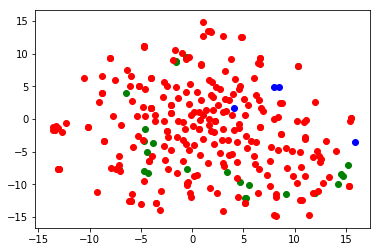

In [184]:
plt.scatter(X_embedded[0:len(a2Q),0], X_embedded[0:len(a2Q),1], color= 'blue')
plt.scatter(X_embedded[len(a2Q):len(a2Q)+len(a2P),0], X_embedded[len(a2Q):len(a2Q)+len(a2P),1], color = 'green')
plt.scatter(X_embedded[len(a2Q)+len(a2P):,0], X_embedded[len(a2Q)+len(a2P):,1], color = 'red')

In [102]:
[word for word in candidateTerms(test['QID'][99], test['Question'][99], 350).keys()]

['god',
 'religious',
 'human',
 'language',
 'beliefs',
 'religion',
 'sense',
 'humans',
 'spiritual',
 'knowledge',
 'buddhism',
 'fundamental',
 'beings',
 'understanding',
 'theory',
 'ancient',
 'religions',
 'values',
 'people',
 'languages',
 'christianity',
 'important',
 'we',
 'nature',
 'respect',
 'moral',
 'origin',
 'belief',
 'common',
 'teachings',
 'meaning',
 'islam',
 'be',
 'of',
 'context',
 'expression',
 'cultural',
 'understand',
 'culture',
 'function',
 'traditions',
 'social',
 'specific',
 'are',
 'true',
 'word',
 'ethnic',
 'is',
 'no',
 'life',
 'muslims',
 'principles',
 'historical',
 'political',
 'it',
 'identity',
 'species',
 'faith',
 'population',
 'genetic',
 'do',
 'person',
 'means',
 'physical',
 'texts',
 'interpretation',
 'great',
 'influence',
 'cultures',
 'evidence',
 'or',
 'individuals',
 'buddhist',
 'terms',
 'defined',
 'countries',
 'principle',
 'if',
 'change',
 'characteristics',
 'biblical',
 'importance',
 'matter',
 'i',
 's

In [45]:
# np.asarray(wordList)[[1,4]]
print(filtered_text)

['relative', 'human', 'beings', 'word', 'jain', 'imply', 'terms', 'dsicpline', 'conquest']


In [145]:
def  popCan(docid, ct):
    example_doc = docs[str(docid)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flat_list = [item for sublist in sentences for item in sublist]
    c = Counter(flat_list)
    
    # The Popular Words
    popct = [word for word, count in c.most_common() if word in ct]
    
    #The non popular words
    nonpop = list(set(ct) - set(popct))
    
    #Stack popular and non popular words
    allw = popct + nonpop
    #Find Embedding
    popctE = vec(allw)
    return popctE

In [159]:
def exEM(row):
    question_text = prepare_question_text(test['QID'][row], test['Question'][row]) ##291
    docid = test['DocumentID'][row]
    ct = candidateTerms(test['QID'][row], test['Question'][row], 300).keys()
#     print((ct))
    a2Q= [word for word in [ w for w in question_text.split() if not w in stop] if word in wordList]
    ##Embedding of popular and non popular query
    popctE = popCan(docid, ct)
    #Embedding of Query terms minus stop words 
    a2QE = vec(a2Q)
    a2QE = np.mean(a2QE, axis =0 ) ##Taking the average of query terms
    X = np.vstack([a2QE, popctE])
    X_embedded = TSNE(n_components=2, verbose = 1, learning_rate=20, perplexity=50, n_iter=5000).fit_transform(X)
    return X_embedded

In [180]:
X_embedded = exEM(222)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.000s...
[t-SNE] Computed neighbors for 301 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 1.744580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.974018
[t-SNE] Error after 1600 iterations: 0.739944


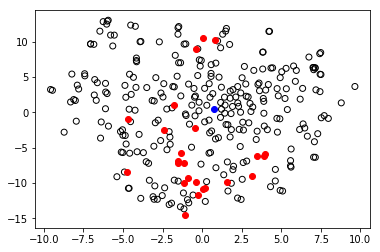

In [181]:

plt.scatter(X_embedded[0,0], X_embedded[0,1], color= 'blue')
# plt.scatter(np.mean(X_embedded[0:3], axis = 0)[0], np.mean(X_embedded[0:3], axis = 0)[1], color= 'blue')

plt.scatter(X_embedded[25:,0], X_embedded[25:,1],  facecolors='none', edgecolors='black')
plt.scatter(X_embedded[1:25,0], X_embedded[1:25,1], color = 'red')